在本篇中，我们将仅用从FTIR输出的原始干涉图开始绘制两个FTIR光谱图。我们为什么会想要这样做，而不只是使用仪器提供的频谱呢？事实证明，将收集的干涉图转换为光谱需要进行相当多的处理步骤，并且这些步骤可能以不同的方式影响光谱。因此，我们希望有时能控制处理方式，以便改进方法来最好地呈现数据。

对于此篇，你需要获取75_BG.txt和75_AIR.txt文件。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

首先，我们需要创建背景光谱。该干涉图是一个名为“75_BG.txt”的以制表符分隔的文本文件，您需要为其设置正确的路径。

In [2]:
filename = "75_BG.txt"
path = ""
data = pd.read_csv(path+filename, header=None, sep='\t', names=["length","inten"])


如果我们在文本文件中绘制数据，我们会找到干涉图，它会告诉我们光是如何在迈克尔逊干涉仪中进行建设性和破坏性干涉的。 

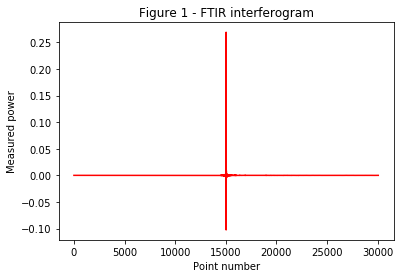

In [3]:
xvals=data['length']
yvals=-data['inten']

plt.plot(xvals,yvals, 'r-')
plt.title("Figure 1 - FTIR interferogram")
plt.xlabel('Point number')
plt.ylabel('Measured power')
plt.show()

目前，这些数据只是测量强度（y轴），还只是一个数字，没有什么意义。我们需要首先将x轴数据转换为迈克尔逊干涉仪两条路径之间的路径长度差。此外，当两条路径的长度相同时，即当路径长度差为零时，会出现15000左右的大峰值。所以我们必须移动所有的x点，然后重新缩放它们。为了转换，我们只需要把中间的0调一下，因为这样看起来大峰在中间。

要重新缩放，我们需要了解FTIR的工作方式。他们的工作方式是，他们有白光和激光沿着光路照射。白光进行所有的光谱分析，而每次光程差正好等于激光波长时，激光告诉计算机何时进行测量。它通过激活开关来实现这一点，每次激光对自身产生建设性干扰。在该光谱中，使用了波长为633nm的HeNe激光器，因此每个数据点对应于改变633nm（或6.33 x 10$^{-5}$cm）的路径长度。

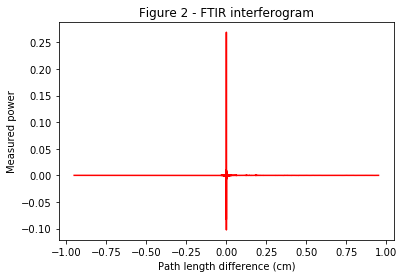

In [4]:
halfpoint = int(xvals.count()/2)
shiftedx = xvals - halfpoint
distanceTraveled = shiftedx * 6.33E-5
plt.plot(distanceTraveled,yvals, 'r-')
plt.title("Figure 2 - FTIR interferogram")
plt.xlabel('Path length difference (cm)')
plt.ylabel('Measured power')
plt.show()

要将干涉图转换为光谱，我们需要对其进行傅立叶变换。为此，我们将使用numpy包中内置的快速傅立叶变换（FFT）算法，该算法被称为FFT（）。因为傅立叶变换可能有复杂的值，我们还需要确保一切都是真实的（这样我们就可以将其绘制出来）。做到这一点最简单（*但不是最好的！*）的方法是将实部和虚部求平方，将它们相加，然后取平方根。所以让我们试一试吧！

In [5]:
fftdata_inter = np.fft.fft(yvals)
specInten_inter=np.sqrt(fftdata_inter.real**2 + fftdata_inter.imag**2)

傅立叶变换后的数据是什么样子的？

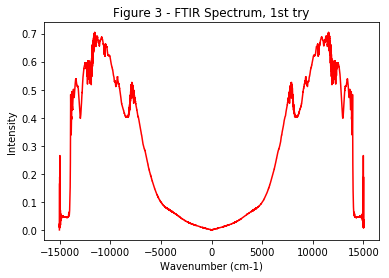

In [6]:
plt.plot(shiftedx,specInten_inter, 'r-')
ax = plt.gca()
plt.title("Figure 3 - FTIR Spectrum, 1st try")
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.show()

我想这看起来像一个光谱，但它有一些问题。首先，x轴很奇怪。事实证明，我需要更加小心，不要使用我上面计算的偏移的x轴。其次，光谱是关于零对称的，FTIR光谱不应该是这样。让我们先解决第二个问题。

尽管我们想用图形中间的峰值来绘制干涉图（即零路径长度差），但出于后处理原因（我不想在这里讨论），我们希望在开始时对峰值进行傅里叶变换。因此，我们需要找到干涉图中峰值的中间位置，并将其作为数据的开始，然后移动干涉图中的所有内容。以下是旋转后的干涉图：

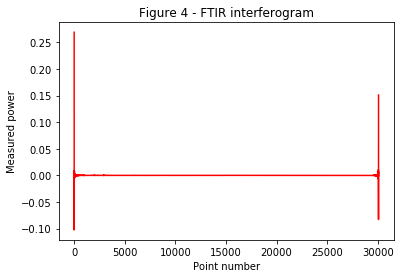

In [7]:
centerMax = yvals.idxmax()
firstHalf = yvals[0:centerMax] 
secondHalf = yvals[centerMax:int(yvals.count())]
rotInten = secondHalf.append(firstHalf, ignore_index=True)

plt.plot(xvals,rotInten, 'r-')
plt.title("Figure 4 - FTIR interferogram")
plt.xlabel('Point number')
plt.ylabel('Measured power')
plt.show()

我现在可以对干涉图进行FFT了。

In [8]:
fftdata = np.fft.fft(rotInten)
specInten=np.sqrt(fftdata.real**2 + fftdata.imag**2)

现在是时候解决另一个问题了，那就是找到正确的x轴。这相当简单，因为它本质上只是路径长度差的倒数。计算这一点的简单方法是将对应于x值的每个点除以总路径长度。

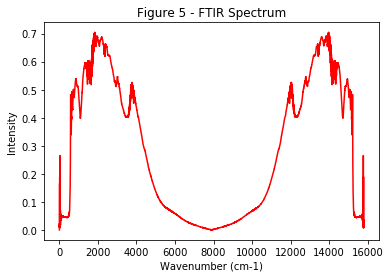

In [9]:
freq = xvals / (xvals.count() * 6.33E-5)
plt.plot(freq, specInten, 'r-')
ax = plt.gca()
plt.title("Figure 5 - FTIR Spectrum")
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.show()

这看起来稍微好一点，但它仍然是对称的。为什么呢？因为迈克尔逊干涉仪中的反射镜向前和向后移动（这就是为什么干涉图大多在零附近对称），所以当我们对干涉图进行傅立叶变换时，它也将是镜像。幸运的是，我们可以忽略光谱的后半部分。

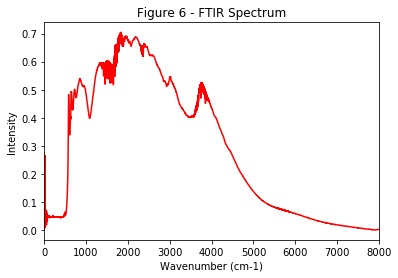

In [10]:
plt.plot(freq, specInten, 'r-')
ax = plt.gca()
ax.set_xlim(0,8000)
plt.title("Figure 6 - FTIR Spectrum")
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.show()

我们有了背景光谱。现在，你可以在第二个文件（75_AIR.txt）中绘制光谱图。

一旦你有了光谱，取你的光谱与我画的背景光谱的比例，乘以100%，然后画出来。他将会给你%T与波数的关系。

重新绘制光谱图，放大3000到4000厘米$^{-1}$之间的区域。

这是空气样本的红外光谱。知道了这是气体的，你如何解释3000到4000厘米$^{-1}$范围内的宽峰由窄峰组成的事实，这些窄峰可以在这个样品中分辨？这些峰对应于什么分子跃迁？

**请在此处回答**

正如我在开头提到的，我们可以对频谱进行后处理。两个最重要的后处理步骤是变迹，这提高了频谱分辨率，以及相位校正，这是FFT后解释实部和虚部之间差异的更好方法。我在这本篇上跳过了这两个，但我鼓励你在[LibeTexts](https://chem.libretexts.org/Textbook_Maps/Analytical_Chemistry/Supplemental_Modules_%28Analytical_Chemistry%29/Instrumental_Analysis/Spectrometer/How_an_FTIR_instrument_works)上阅读更多关于它们的内容。